### Group:
- Nooshin Shojaee
- Francesco Ciraolo
- Lucas Souza Romao

### Enviroments Setup

In [450]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers, optimizers
from keras.models import Sequential

from sklearn.model_selection import train_test_split

from PIL import Image
import imghdr

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import pandas as pd
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [451]:
train_pics_dir = '/home/lucas/Documents/ML_FinalProject/train/train/'
test_pics_dir = '/home/lucas/Documents/ML_FinalProject/test/test/'

### Data Preprocessing

- First check if the image are the type 'gif', if yes remove from the DataFrame, train and test set gif type are less than 1% of the total, so the files are drop from the DataFrames

In [452]:
def filter_images(dataset):
    
     dataset = dataset.set_index('file_name')
     
     for file in dataset.index:
         if (imghdr.what(file) == 'gif'):
            dataset = dataset.drop(file)
             
     return dataset.reset_index()  

In [453]:
def add_labels_dataframe(dataset):
    
    df = dataset.copy()
    
    for column in df.loc[:, df.columns != 'file_name']:
        df[column]= df[column].replace(1,df[column].name)
    
    df['classes'] = df.loc[:, (df.columns != 'file_name')].values.tolist()
    df['classes']= df['classes'].apply(lambda x : list(filter(lambda b: b != 0, x)))
    
    return df['classes']

In [454]:
test_df = pd.read_csv('test/test.anno.txt', sep=" ")
labels = test_df.columns
test_df['file_name'] = test_df['file_name'].apply(lambda x: os.path.join(test_pics_dir, x))
test_df.head()

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal
0,/home/lucas/Documents/ML_FinalProject/test/tes...,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1
1,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
2,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,1,0,0,0,1,1,1,1,0,0,1,0,0,1,0
3,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0
4,/home/lucas/Documents/ML_FinalProject/test/tes...,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,0


In [455]:
train_df = pd.read_csv('train/train.anno.txt', sep=" ", names=labels)
train_df['file_name'] = train_df['file_name'].apply(lambda x: os.path.join(train_pics_dir, x))
#train_df['classes'] = add_labels_dataframe(train_df)
train_df['classes'] = train_df.loc[:, (train_df.columns != 'file_name')].values.tolist()
train_df.head()

,file_name,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal,classes
0,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,0,1,0,0,1,1,1,0,0,1,0,0,0,0,"[0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, ..."
1,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, ..."
2,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,"[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ..."
3,/home/lucas/Documents/ML_FinalProject/train/tr...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,/home/lucas/Documents/ML_FinalProject/train/tr...,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,"[0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [456]:
train_df = filter_images(train_df)
test_df = filter_images(test_df)

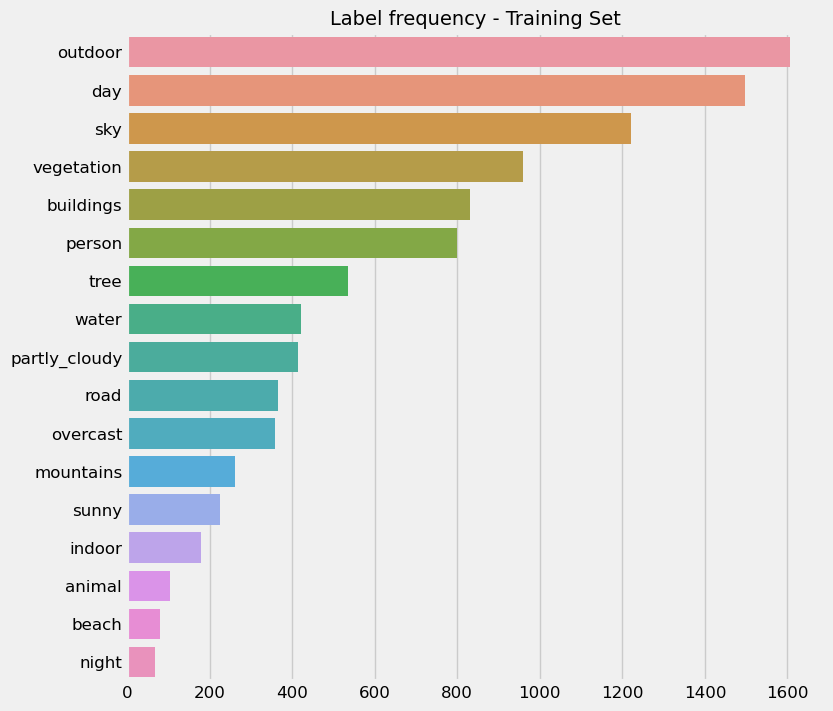

In [457]:
labels_freq = []

for column in train_df:
    if train_df[column].name != 'file_name' and train_df[column].name != 'classes':
        labels_freq.append(
            [train_df[column].name, 
             train_df[column].value_counts()[1]
            ])

df_labels_freq = pd.DataFrame(labels_freq, columns = ['Label', 'Count']).sort_values(by=['Count'], ascending=False)


# Bar plot
style.use("fivethirtyeight")
plt.figure(figsize=(8,8))
sns.barplot(y=df_labels_freq.Label, x=df_labels_freq.Count)
plt.title("Label frequency - Training Set", fontsize=14)
plt.xlabel("")
plt.ylabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

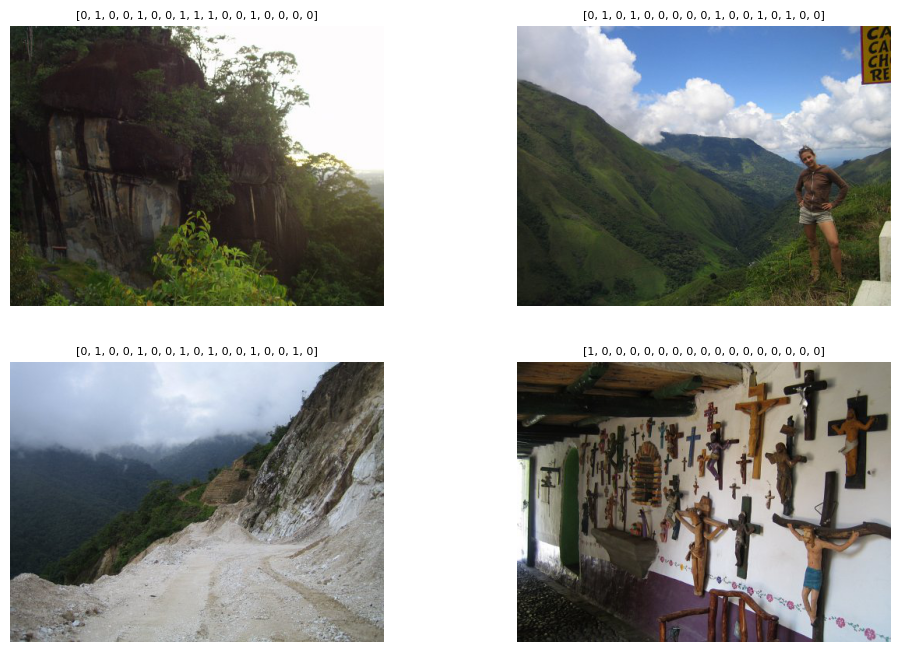

In [458]:
nobs = 4 
ncols = 2
nrows = nobs//ncols

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(4):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(train_df['file_name'][i]))
    plt.title(train_df['classes'][i], size=8)
    plt.axis('off')

### Data Argumentation

Add here later

In [459]:
CHANNELS = 3
IMG_HEIGHT = 260
IMG_WIDTH = 260
BATCH_SIZE = 16 
AUTOTUNE = tf.data.experimental.AUTOTUNE # Adapt preprocessing and prefetching dynamically
SHUFFLE_BUFFER_SIZE = 500 # Shuffle the training data by a chunck of 1024 observations

In [460]:
def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = tf.image.resize(image_decoded, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [461]:
def create_dataset(filenames, labels):
    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
        
    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    
    return dataset

In [462]:
X_train, X_val, y_train, y_val = train_test_split(train_df['file_name'], train_df['classes'], test_size=0.2, random_state=44)

In [463]:
train_ds = create_dataset(X_train, list(y_train))
val_ds = create_dataset(X_val, list(y_val))

### Dataset Generators

Easy way 

In [464]:
# ## We don't want test set to be suffle or have more than one batch size, it need to be almost untouch 
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,
                                                directory=test_pics_dir,
                                                x_col='file_name',
                                                y_col=None,
                                                batch_size=1,
                                                seed = 44,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 997 validated image filenames.


### Model 

- Very simple one, needs to improve

In [466]:
from tensorflow.keras.applications import EfficientNetB2, MobileNetV2, ResNet50

In [433]:
effic_b2 = EfficientNetB2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))


In [400]:
v2 = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))


In [483]:
res50 = ResNet50(weights='imagenet',include_top=False, pooling='max', input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))

In [484]:
model = Sequential()
model.add(res50)
model.add(Dense(1024, activation='relu'))
model.add(Dense(17, activation='sigmoid'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_39 (Dense)             (None, 17)                17425     
Total params: 25,703,313
Trainable params: 25,650,193
Non-trainable params: 53,120
_________________________________________________________________


In [485]:
#opt = optimizers.SGD(lr=1e-5, momentum=0.9)
#model.compile(optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])
#model.compile(optimizer=opt,loss = 'categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizers.Adam(lr=1e-5),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [486]:
STEP_SIZE_TRAIN=len(train_ds)//BATCH_SIZE
STEP_SIZE_VALID=len(val_ds)//BATCH_SIZE
#STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [487]:
earlystop_callback = EarlyStopping(
  monitor='val_loss', mode='auto', min_delta=0.0001,
  patience=5)

rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1,
                        mode='auto', 
                        min_delta=0.0001)

In [488]:
with tf.device('/gpu:0'):
    history = model.fit(
            train_ds,
            epochs = 20,
            callbacks=[earlystop_callback],
            validation_data=val_ds,
    )

Epoch 1/20
92/92 [==============================] - 36s 397ms/step - loss: 16.5483 - accuracy: 0.8595 - val_loss: 16.7700 - val_accuracy: 0.9205
Epoch 2/20
92/92 [==============================] - 36s 389ms/step - loss: 16.4856 - accuracy: 0.8705 - val_loss: 16.7700 - val_accuracy: 0.9205
Epoch 3/20
92/92 [==============================] - 36s 389ms/step - loss: 16.4856 - accuracy: 0.8705 - val_loss: 16.7700 - val_accuracy: 0.9205
Epoch 4/20
92/92 [==============================] - 36s 391ms/step - loss: 16.4856 - accuracy: 0.8705 - val_loss: 16.7700 - val_accuracy: 0.9205
Epoch 5/20
92/92 [==============================] - 36s 390ms/step - loss: 16.4856 - accuracy: 0.8705 - val_loss: 16.7700 - val_accuracy: 0.9205
Epoch 6/20
92/92 [==============================] - 36s 389ms/step - loss: 16.4856 - accuracy: 0.8705 - val_loss: 16.7700 - val_accuracy: 0.9205


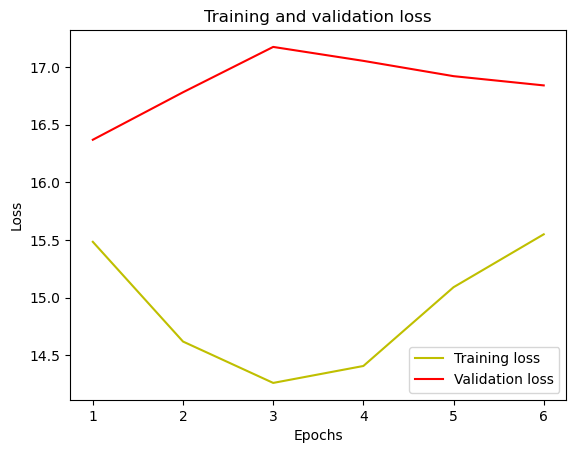

In [444]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [340]:
test_generator.reset()
pred= model.predict(test_generator,steps=STEP_SIZE_TEST, verbose=1)

997/997 [==============================] - 14s 14ms/step


In [341]:
df = pd.DataFrame(data=pred, columns=labels[1:].to_list())

In [342]:
df

,indoor,outdoor,person,day,night,water,road,vegetation,tree,mountains,beach,buildings,sky,sunny,partly_cloudy,overcast,animal
0,0.065212,0.051731,0.056200,0.058920,0.059298,0.061315,0.052699,0.050522,0.055466,0.061867,0.060022,0.057816,0.063767,0.066854,0.051462,0.063461,0.063390
1,0.065233,0.051771,0.056151,0.058935,0.059321,0.061220,0.052733,0.050473,0.055425,0.061911,0.060056,0.057760,0.063787,0.066825,0.051535,0.063458,0.063406
2,0.065182,0.051725,0.056231,0.058903,0.059286,0.061384,0.052684,0.050552,0.055470,0.061835,0.059990,0.057829,0.063752,0.066896,0.051424,0.063460,0.063398
3,0.065162,0.051703,0.056256,0.058888,0.059266,0.061456,0.052649,0.050606,0.055485,0.061806,0.059980,0.057851,0.063740,0.066922,0.051350,0.063469,0.063409
4,0.065197,0.051740,0.056217,0.058904,0.059285,0.061314,0.052718,0.050538,0.055465,0.061857,0.060018,0.057810,0.063759,0.066868,0.051463,0.063464,0.063382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,0.065240,0.051743,0.056216,0.058918,0.059348,0.061309,0.052732,0.050513,0.055417,0.061831,0.060020,0.057802,0.063788,0.066799,0.051436,0.063502,0.063386
993,0.065248,0.051752,0.056167,0.058942,0.059310,0.061199,0.052772,0.050454,0.055459,0.061904,0.060070,0.057779,0.063766,0.066793,0.051551,0.063462,0.063373
994,0.065289,0.051820,0.056167,0.058952,0.059356,0.061144,0.052813,0.050363,0.055372,0.061917,0.060015,0.057752,0.063831,0.066808,0.051623,0.063417,0.063361
995,0.065183,0.051714,0.056193,0.058914,0.059288,0.061361,0.052657,0.050571,0.055481,0.061857,0.060032,0.057809,0.063750,0.066878,0.051418,0.063483,0.063410
